# cml1 - Immobilienrechner
# Data Wrangling
In diesem Notebook konzentrieren wir uns darauf, Rohdaten in eine saubere, analysierbare Form zu bringen. Data Wrangling, auch bekannt als Data Munging, ist ein entscheidender Schritt in der Datenanalyse, um sicherzustellen, dass die Daten korrekt und effizient interpretiert und analysiert werden können.

## Bibliotheken importieren

In [1]:
import pandas as pd
import numpy as np
import re

## Daten laden

In [2]:
df = pd.read_csv('../../data/immo_data_202208_v2.csv', low_memory=False)
print(df.shape)

(22481, 134)


Wir haben 22'481 Zeilen (Immobilien) und 134 Spalten (Merkmale) in unserem Datensatz.

In [3]:
# print all columns, so we can see all columns
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0.1,Unnamed: 0,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,url,table,Floor,detail_responsive#municipality,detail_responsive#surface_living,detail_responsive#floor,detail_responsive#available_from,Gemeinde,Wohnfläche,Stockwerk,Nutzfläche,Verfügbarkeit,Grundstücksfläche,detail_responsive#surface_property,detail_responsive#surface_usable,Commune,Surface habitable,Surface du terrain,Surface utile,Disponibilité,Étage,Comune,Superficie abitabile,Disponibilità,Gross return,Piano,Superficie del terreno,Superficie utile,Municipality_merged,Floor_merged,Living_space_merged,Floor_space_merged,Plot_area_merged,Availability_merged,location_parsed,title,details,address,price,link,details_structured,lat,lon,index,ForestDensityL,ForestDensityM,ForestDensityS,Latitude,Locality,Longitude,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,PopulationDensityM,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,Zip,distanceToTrainStation,gde_area_agriculture_percentage,gde_area_forest_percentage,gde_area_nonproductive_percentage,gde_area_settlement_percentage,gde_average_house_hold,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_politics_bdp,gde_politics_cvp,gde_politics_evp,gde_politics_fdp,gde_politics_glp,gde_politics_gps,gde_politics_pda,gde_politics_rights,gde_politics_sp,gde_politics_svp,gde_pop_per_km2,gde_population,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,price_cleaned,type,Space extracted,rooms,plz_parsed,type_unified,Floor_unified,Plot_area_unified,Living_area_unified,provider,space,price_s,address_s,No. of rooms:,Number of apartments:,Surface living:,Land area:,Room height:,Last refurbishment:,Year built:,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
0,0,0,Biberstein,100 m²,NaN,NaN,On request,"5023 Biberstein, AG","3.5 rooms, 100 m²«Luxuriöse Attika-Wohnung mit...",DescriptionLuxuriöse Attika-Wohnung direkt an ...,https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,4. floor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Biberstein,4. floor,100 m²,NaN,NaN,On request,Strasse: plz:5023 Stadt: Biberstein Kanton: AG,Luxuriöse Attika-Wohnung mit herrlicher Aussicht,"3.5 rooms, 100 m²,","5023 Biberstein, AG","CHF 1,150,000.—",/en/d/penthouse-buy-biberstein/7255200,"{'Municipality': 'Biberstein', 'Living space':...",47.417100,8.085600,16620,0.511176,0.286451,0.090908,47.415927,Biberstein,8.085840,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,5023,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1150000.0,penthouse,100.0,5.0,5023.0,penthouse,4,NaN,100.0,Immoscout24.ch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
1,1,1,Biberstein,156 m²,222 m²,242 m²,On request,"Buhldenstrasse 8d5023 Biberstein, AG","4.5 rooms, 156 m²«Stilvolle Liegenschaft - ruh...",DescriptionStilvolle Liegenschaft an ruhiger L...,https://www.immoscout24.ch//en/d/terrace-house...,b <article class=####Box-cYFBPY hKrxoH####><h2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Biberstein,NaN,156 m²,242 m²,222 m²,On request,Strasse:Buhldenstrasse 8d plz:5023 Stadt: Bib...,"Stilvolle Liegenschaft - ruhige Lage, unverbau...","4.5 rooms, 156 m²,","Buhldenstrasse 8d, 5023 Biberstein, AG","CHF 1,420,000.—",/en

## Konvertieren von Datentypen

Hier gehen wir die Spalte "details_structured" durch. Wir prüfen, ob es Werte in dieser Spalte gibt, die nicht im Dataframe vorhanden sind. Diese Überprüfung gelingt uns, wenn wir die Spalte "details_structured" in ein Dictionary konvertieren und die Schlüssel des Dictionaries mit den Spaltennamen des Dataframes übereinstimmen. Anschließend wird überprüft, ob der Wert bereits in der Spalte vorhanden ist. Wenn nicht, wird er hinzugefügt.

In [4]:
import ast

def convert_to_dict(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except:
            return {}
    elif isinstance(val, dict):
        return val
    else:
        return {}

df['details_structured'] = df['details_structured'].apply(convert_to_dict)

In [5]:
def update_row_values(row):
    details = row['details_structured']
    for key, value in details.items():
        if key in df.columns and pd.isna(row[key]):
            row[key] = value
    return row

df = df.apply(update_row_values, axis=1)

## Ähnliche Spalten

Wir haben festgestellt, dass es zahlreiche Spalten gibt, die äquivalente Informationen tragen, allerdings in verschiedenen Sprachen oder unter verschiedenen Bezeichnungen. Um keine wertvollen Daten zu verlieren, beabsichtigen wir, diese äquivalenten Spalten in diesem Abschnitt zu vereinen. Zunächst müssen wir jedoch ermitteln, welche dieser Spalten die meisten Informationen enthält, um als Hauptspalte für das Zusammenführen zu dienen. Dies erreichen wir durch das Zählen der fehlenden Werte in jeder Spalte.

### Preis Spalten

In [6]:
lst = ['price', 'price_s', 'price_cleaned']
for i in lst:
    print(i, "-", df[i].isna().sum())

price - 0
price_s - 13355
price_cleaned - 1015


price_cleaned hat 1015 NA-Werte. Schauen wir uns price_cleaned und price an, wo price_cleaned NA-Werte hat.

In [7]:
df[df['price_cleaned'].isna()][['price', 'price_cleaned']]['price'].value_counts()

price
Price on request    1015
Name: count, dtype: int64

price hat zwar keine fehlende Werte, aber die Spalte enthält Währungen und Texte. Überall wo price_cleaned NA-Werte hat, hat price den Text "Price on request". 

→ Am Einfachsten hier ist, die Spalte price_cleaned als Hauptspalte zu nehmen. Hier ist kein Merge nötig.

Da der Preis unsere Zielvariable ist, werden wir alle Zeilen mit NA-Werte aus dem Datensatz löschen.

In [8]:
df = df[df['price_cleaned'].notna()] 

### Wohnfläche Spalten

In [9]:
lst = ['Space extracted', 'Living space', 'detail_responsive#surface_living', 'Wohnfläche', 'Surface habitable', 'Superficie abitabile', 'Living_space_merged', 'Surface living:', 'Living_area_unified', 'space_cleaned']
for i in lst:
    print(i, "-", df[i].isna().sum())

Space extracted - 1301
Living space - 10649
detail_responsive#surface_living - 21068
Wohnfläche - 21331
Surface habitable - 21405
Superficie abitabile - 21440
Living_space_merged - 10427
Surface living: - 12340
Living_area_unified - 1301
space_cleaned - 12340


Wir sehen, `Space extracted` und `Living_area_unified` haben gleich viele NA-Werte. Schauen wir nun, ob diese beiden Spalten die gleichen Werte haben.

In [10]:
df['Space extracted'] = df['Space extracted'].astype(float)
df['Living_area_unified'] = df['Living_area_unified'].astype(float)
df['Space extracted'].equals(df['Living_area_unified'])

True

→  Wir werden also `Living_area_unified` als Hauptspalte mit allen anderen Wochnfläche-Spalten mergen.

### Gemeinde Spalten

In [11]:
lst = ['Municipality', 'detail_responsive#municipality', 'Gemeinde', 'Commune', 'Comune', 'Municipality_merged']
for i in lst:
    print(i, "-", df[i].isna().sum())

Municipality - 856
detail_responsive#municipality - 21048
Gemeinde - 21326
Commune - 21404
Comune - 21440
Municipality_merged - 9754


→  Wir werden also 'Municipality' als Hauptspalte mit allen anderen Wochnfläche-Spalten mergen.

### Verfügbarkeit Spalten

In [12]:
lst = ['Availability', 'detail_responsive#available_from', 'Verfügbarkeit', 'Disponibilité', 'Disponibilità', 'Availability_merged']

for i in lst:
    print(i, "-", df[i].isna().sum())

Availability - 9784
detail_responsive#available_from - 21040
Verfügbarkeit - 21324
Disponibilité - 21403
Disponibilità - 21439
Availability_merged - 9552


→  Wir werden 'Availability_merged' als Hauptspalte mit allen anderen Verfügbarkeit-Spalten mergen.

Was hier wichtig zu beachten ist, ist dass die Spalte kategorisch ist und viele verschiedene Verfügbarkeits-Daten enthält. Wir werden diese Spalte in den nächsten Schritten weiter bereinigen.

In [13]:
df['Availability_merged'].unique()[:10]

array(['On request', nan, 'Immediately', '30.12.2022', '01.12.2022',
       '01.04.2023', '01.08.2023', '01.10.2022', '01.11.2022',
       '01.09.2023'], dtype=object)

### Stockwerk Spalten

In [14]:
lst = ['Floor', 'Floor_unified', 'detail_responsive#floor', 'Étage', 'Piano','Stockwerk', 'Floor_merged']

for i in lst:
    print(i, "-", df[i].isna().sum())

Floor - 11770
Floor_unified - 16413
detail_responsive#floor - 21268
Étage - 21442
Piano - 21456
Stockwerk - 21407
Floor_merged - 16320


→  Wir werden 'Floor' als Hauptspalte mit allen anderen Stockwerk-Spalten mergen.

### Nutzfläche Spalten

In [15]:
lst = ['Floor space', 'Nutzfläche', 'detail_responsive#surface_usable', 'Surface utile', 'Superficie utile', 'Floor_space_merged']
for i in lst:
    print(i, "-", df[i].isna().sum())

Floor space - 18853
Nutzfläche - 21428
detail_responsive#surface_usable - 21362
Surface utile - 21453
Superficie utile - 21460
Floor_space_merged - 18796


→  Wir werden 'Floor_space_merged' als Hauptspalte mit allen anderen Nutzfläche-Spalten mergen.

### Grundstücksfläche Spalten

In [16]:
lst = ['Plot area', 'detail_responsive#surface_property', 'Grundstücksfläche', 'Surface du terrain', 'Superficie del terreno', 'Plot_area_merged', 'Plot_area_unified', 'Land area:']
for i in lst:
    print(i, "-", df[i].isna().sum())

Plot area - 17260
detail_responsive#surface_property - 21325
Grundstücksfläche - 21412
Surface du terrain - 21441
Superficie del terreno - 21456
Plot_area_merged - 17171
Plot_area_unified - 13991
Land area: - 18197


→  Wir werden 'Plot_area_unified' als Hauptspalte mit allen anderen Grundstückfläche-Spalten mergen.

### Postleitzahl Spalten

In [17]:
lst = ['Zip', 'plz', 'plz_parsed']
for i in lst:
    print(i, "-", df[i].isna().sum())

Zip - 0
plz - 13
plz_parsed - 13


→ Hauptspalte: 'Zip'. Hier ist ebenfalls kein Merge nötig.

### Zimmer Spalten

- rooms
- No. of rooms:
- details

Uns ist hier aufgefallen, dass die Werte für die Anzahl Zimmer in der Spalten 'rooms' und 'description' meistens abweichen. Wir werden nun eine neue Spalte "Rooms_new" erstellen, die die Werte aus der Spalte 'description' übernimmt, damit wir die beiden Spalten besser vergleichen können.

In [18]:
def extract_rooms(description):
    if isinstance(description, str):
        match = re.search(r'(\d+(\.\d)?)\s*(rooms|Zimmer|Zimmerwohnung)', description)
        if match:
            return float(match.group(1))
    else:
        return np.nan

# Use `assign` method to create the new column
df = df.assign(Rooms_new=df['description'].apply(extract_rooms))

df[['description', 'Rooms_new']]

,description,Rooms_new
0,"3.5 rooms, 100 m²«Luxuriöse Attika-Wohnung mit...",3.5
1,"4.5 rooms, 156 m²«Stilvolle Liegenschaft - ruh...",4.5
2,"2.5 rooms, 93 m²«Moderne, lichtdurchflutete At...",2.5
3,"4.5 rooms, 154 m²«AgentSelly - Luxuriöses Eckh...",4.5
4,"4.5 rooms, 142 m²«MIT GARTENSITZPLATZ UND VIEL...",4.5
...,...,...
22476,NaN,NaN
22477,NaN,NaN
22478,NaN,NaN
22479,NaN,NaN


In [19]:
df[['rooms', 'Rooms_new']].head(10)

,rooms,Rooms_new
0,5.0,3.5
1,5.0,4.5
2,5.0,2.5
3,5.0,4.5
4,5.0,4.5
5,5.0,5.5
6,5.0,4.5
7,5.0,4.5
8,5.0,3.5
9,5.0,4.5


Wenn wir nun die beiden Spalten vergleichen, sehen wir, dass die Werte nicht übereinstimmen.

In [20]:
lst = ['Rooms_new', 'rooms', 'No. of rooms:']
for i in lst:
    print(i, "-", df[i].isna().sum())

Rooms_new - 9198
rooms - 697
No. of rooms: - 12598


"Rooms_new" hat zwar viel mehr fehlende Werte, aber wir gehen davon aus, dass die Spalte "description" mit den Anzahl Zimmer genauer ist als die Spalte "rooms", da dies die Beschreibung der Immobilie ist. Von wo die Werte aus der Spalte "rooms" stammen, ist nicht klar.

→ Deshalb nehmen wir die neu erstellte Spalte "Rooms_new" als Hauptspalte und mergen bei den NA-Werten mit den Spalten "rooms"

### Immo Typ

In [21]:
df['type_unified'].value_counts()

type_unified
flat                              10511
detached-house                     5164
villa                              1163
semi-detached-house                 818
duplex-maisonette                   686
attic-flat                          674
chalet                              665
penthouse                           622
terrace-house                       497
stepped-apartment                   206
farmhouse                           152
studio                               95
rustico                              64
stepped-house                        57
loft                                 42
furnished-residential-property       24
attic-room                           12
castle                                6
detached-secondary-suite              4
single-room                           3
secondary-suite                       1
Name: count, dtype: int64

### Andere Spalten
Es gibt noch viele andere Spalten, die äquivalente Informationen tragen, wie 'location', 'location_parsed', 'address' etc. Aber diese Spalten werden wir für das Projekt nicht verwenden, da wir kein Natural Language Processing integrieren werden.

## Spalten zusammenführen

Nachdem wir die Haupt-Spalten bestummen haben, können wir nun die Spalten mergen. Schauen wir aber zuerst noch die Anzahl NA-Werte der zu mergenden Spalten an, damit wir wissen, wie viele NA-Werte wir nach dem Mergen haben werden.

In [22]:
print(df['Living_area_unified'].isna().sum())
print(df['Municipality'].isna().sum())
print(df['Availability_merged'].isna().sum())
print(df['Floor_unified'].isna().sum())
print(df['Floor_space_merged'].isna().sum())
print(df['Plot_area_unified'].isna().sum())
print(df['Rooms_new'].isna().sum())

1301
856
9552
16413
18796
13991
9198


In [23]:
def merge_columns(row, main_column, columns_to_merge):
    if pd.isna(row[main_column]):
        for col in columns_to_merge:
            if pd.notna(row[col]):
                row[main_column] = row[col]
                break
    return row

df = df.apply(lambda row: merge_columns(row, 'Living_area_unified', ['Living space', 'detail_responsive#surface_living', 'Wohnfläche', 'Surface habitable', 'Superficie abitabile', 'Living_space_merged', 'Surface living:', 'Space extracted', 'space_cleaned']), axis=1)
df = df.apply(lambda row: merge_columns(row, 'Municipality', ['detail_responsive#municipality', 'Gemeinde', 'Commune', 'Comune', 'Municipality_merged']), axis=1)
df = df.apply(lambda row: merge_columns(row, 'Availability_merged', ['Availability', 'detail_responsive#available_from', 'Verfügbarkeit', 'Disponibilité', 'Disponibilità']), axis=1)
df = df.apply(lambda row: merge_columns(row, 'Floor_unified', ['detail_responsive#floor', 'Étage', 'Piano','Stockwerk', 'Floor_merged', 'Floor']), axis=1)
df = df.apply(lambda row: merge_columns(row, 'Floor_space_merged', ['Floor space', 'Nutzfläche', 'detail_responsive#surface_usable', 'Surface utile', 'Superficie utile']), axis=1)
df = df.apply(lambda row: merge_columns(row, 'Plot_area_unified', ['Plot area', 'detail_responsive#surface_property', 'Grundstücksfläche', 'Surface du terrain', 'Superficie del terreno', 'Plot_area_merged', 'Land area:']), axis=1)
df = df.apply(lambda row: merge_columns(row, 'Rooms_new', ['rooms', 'No. of rooms:']), axis=1)

Überprüfen wir die Zusammenführungen der Spalten.

In [24]:
print(df['Living_area_unified'].isna().sum())
print(df['Municipality'].isna().sum())
print(df['Availability_merged'].isna().sum())
print(df['Floor_unified'].isna().sum())
print(df['Floor_space_merged'].isna().sum())
print(df['Plot_area_unified'].isna().sum())
print(df['Rooms_new'].isna().sum())

903
210
9126
11479
18692
13761
669


Die Ergebnisse zeigen, dass wir durch das Merging von Spalten eine erhebliche Menge an Daten "retten" konnten, die sonst verloren gegangen wären. Dies verbessert die Datendichte und die mögliche Aussagekraft unserer nachfolgenden Analysen erheblich.

## Kantone hinzufügen

Hier werden wir die Kantone zu den PLZ hinzufügen. Wir verwenden dazu die offizielle Liste der Postleitzahlen der Schweiz.

Quelle: [Swisspost Opendatasoft](https://swisspost.opendatasoft.com/api/explore/v2.1/catalog/datasets/plz_verzeichnis_v2/exports/csv)

In [25]:
df_plz = pd.read_csv('../../data/plz_verzeichnis_v2.csv', sep=';')
df_plz = df_plz[['GPLZ', 'KANTON']]
df_plz = df_plz.rename(columns={'GPLZ': 'gplz', 'KANTON': 'kanton'})

# Remove duplicates
df_plz = df_plz.drop_duplicates(subset=['gplz'], keep='first')

# Merge with main dataframe
df = df.merge(df_plz, left_on='Zip', right_on='gplz', how='left')

## Spalten Vereinheitlichen

Hier werden wir die Werte in den Spalten vereinheitlichen, z.B. Einheiten oder Vorzeichen entfernen und in numerische / kategorische Werte umwandeln.

In [26]:
def clean_area_values(column):
    column = column.astype(str)
    column = column.str.replace(' m²', '').str.replace(' m2', '')
    column = column.str.replace(',', '')
    column = pd.to_numeric(column, errors='coerce')
    return column

def clean_floor_values(column):
    column = column.astype(str)
    column = column.str.split('.', expand=True)[0]
    column = column.str.replace('.', '')
    column = column.str.replace('Ground floor', '0', case=False)
    column = column.str.replace('GF', '0', case=False)
    column = pd.to_numeric(column, errors='coerce')
    return column

def clean_room_values(column):
    column = column.astype(str)
    column = column.str.replace('rm', '', case=False)
    column = pd.to_numeric(column, errors='coerce')
    return column
    
def clean_type(x):
    """
    Returns "Other" if the property type has less than 30 entries, except for 'castle'
    """
    if x == 'castle':
        return x
    
    if x in df['type_unified'].value_counts()[df['type_unified'].value_counts() > 30].index:
        return x
    else:
        return "Other" 

def clean_zip(x):
    """
    Returns the first 2 digits of the zip code to unify the zip codes (example: 5000 and 5001 both become 50)
    """
    return str(x)[:2]
    
def to_date(x):
    """
    Convert the date strings to datetime format for easy comparison
    """
    try:
        return pd.to_datetime(x, format='%d.%m.%Y')
    except:
        return x
    
def categorize_availability(x):
    """
    Categorize the dates into broader time periods
    """
    today = pd.Timestamp.today()
    
    if x == "On request":
        return "On request"
    elif x == "Immediately":
        return "Immediately"
    elif (x - today).days <= 30:
        return "Within 1 month"
    elif (x - today).days <= 90:
        return "Within 3 months"
    elif (x - today).days <= 180:
        return "Within 6 months"
    else:
        return "More than 6 months"
    
# Apply the cleaning functions
df['Living_area_unified'] = clean_area_values(df['Living_area_unified'])
df['Floor_unified'] = clean_floor_values(df['Floor_unified'])
df['Floor_space_merged'] = clean_area_values(df['Floor_space_merged'])
df['Plot_area_unified'] = clean_area_values(df['Plot_area_unified'])
df['Rooms_new'] = clean_room_values(df['Rooms_new'])
df['type_unified'] = df['type_unified'].apply(clean_type)
df['Zip'] = df['Zip'].apply(clean_zip)
df['Availability_merged'] = df['Availability_merged'].apply(to_date)
df['Availability_Categorized'] = df['Availability_merged'].apply(categorize_availability)

df = df.copy().drop(columns=['Availability_merged'])

/var/folders/l1/7lm0cqd933xgjvldmnsjpphh0000gn/T/ipykernel_29642/1141843429.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Availability_Categorized'] = df['Availability_merged'].apply(categorize_availability)


## Variablenselektion

Basierend auf unserer Datensäuberung und Erkenntnisse werden wir folgende Variablen für die Modellierungen berücksichtigen:

In [27]:
columns_to_keep = [
	"price_cleaned", 
	"kanton",
	"Zip",
	"Year built:",
	"type_unified",
	"Availability_Categorized",
	"Living_area_unified",
	"Floor_unified", 
	"Floor_space_merged",
	"Plot_area_unified", 
	"Rooms_new",

    "distanceToTrainStation",

    "gde_workers_sector1", "gde_workers_sector2", "gde_workers_sector3", "gde_workers_total", 
    "gde_area_agriculture_percentage", 
    "gde_area_forest_percentage", 
    "gde_area_nonproductive_percentage", 
    "gde_area_settlement_percentage", 
    "gde_average_house_hold", 
    "gde_empty_apartments", 
    "gde_foreigners_percentage", 
    "gde_new_homes_per_1000", 
    "gde_pop_per_km2", 
    "gde_population", 
    "gde_private_apartments", 
    "gde_social_help_quota", 
    "gde_tax", 

    "gde_politics_bdp",
    "gde_politics_cvp",
    "gde_politics_evp",
    "gde_politics_fdp",
    "gde_politics_glp",
    "gde_politics_gps",
    "gde_politics_pda",
    "gde_politics_rights",
    "gde_politics_sp",
    "gde_politics_svp",

    "NoisePollutionRailwayL", "NoisePollutionRailwayM", "NoisePollutionRailwayS", 
    "NoisePollutionRoadL", "NoisePollutionRoadM", "NoisePollutionRoadS", 
    "PopulationDensityL", "PopulationDensityM", "PopulationDensityS", 
    "RiversAndLakesL", "RiversAndLakesM", "RiversAndLakesS", 
    "WorkplaceDensityL", "WorkplaceDensityM", "WorkplaceDensityS", 
    "ForestDensityL", "ForestDensityM", "ForestDensityS"
]

df = df[columns_to_keep]

print(df.shape)

(21466, 57)


## Fehlende Werte

In [28]:
# Check for missing values
missing_data = df.isna().sum().sort_values(ascending=False)
missing_percentage = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False) * 100

# Combine the results into a single DataFrame
missing_df = pd.concat([missing_data, missing_percentage], axis=1, keys=['Total Missing', 'Percentage (%)'])
missing_df.head(10)

,Total Missing,Percentage (%)
Floor_space_merged,18692,87.077238
Year built:,14533,67.702413
Plot_area_unified,13761,64.106028
Floor_unified,11479,53.475263
gde_politics_pda,10284,47.908320
gde_politics_bdp,8488,39.541601
gde_politics_rights,6466,30.122053
gde_politics_glp,5691,26.511693
gde_politics_evp,4001,18.638778
Living_area_unified,903,4.206652


Oben sehen wir die Spalten mit den meisten NA nachdem wir die Daten gesäubert und zusammengeführt haben. Die Liste beinhaltet viele Gemeinde-Spalten. Wir betrachten bei `Floor_space_merged` eine Anzahl von 18'692 (87%) fehlenden Werten. Eventuell wäre es sinnvoll, diese Variable zu entfernen.

In [29]:
# Define a threshold for missing values (e.g., 80%)
threshold = 80

# Get the columns that have less than 80% missing values
columns_to_keep = missing_df[missing_df['Percentage (%)'] < threshold].index

# Keep only the columns that have less than 80% missing values
df = df[columns_to_keep]

print(df.shape)

(21466, 56)


## Ausreisser

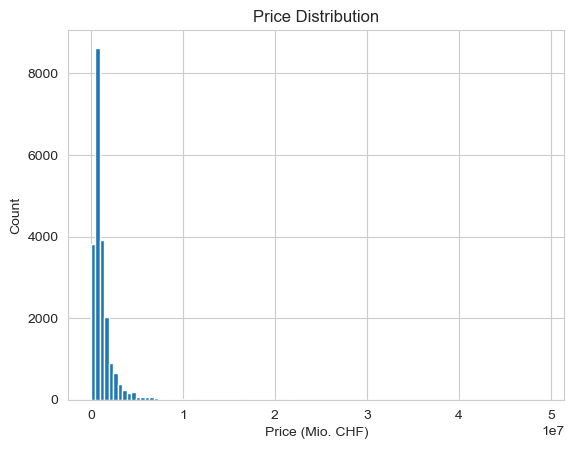

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

df['price_cleaned'].hist(bins=100)
plt.xlabel('Price (Mio. CHF)')
plt.ylabel('Count')
plt.title('Price Distribution')
plt.show()

In [31]:
# perform IQR outlier detection on the price_cleaned column
Q1 = df['price_cleaned'].quantile(0.1)
Q3 = df['price_cleaned'].quantile(0.75)
print(Q1, Q3)

IQR = Q3 - Q1
print(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# ACHTUNG für Q1 habe ich nicht die Q1 - 1.5 * IQR genommen sondern direkt Q1 da der Wert sonst unter 0 wäre
df_cleaned = df[(df['price_cleaned'] >= (Q1)) & (df['price_cleaned'] <= (Q3 + 1.5 * IQR))]

# print min and max values after outlier removal
print(df_cleaned['price_cleaned'].min())
print(df_cleaned['price_cleaned'].max())

385000.0 1418000.0
-1164500.0 2967500.0
385000.0
2960000.0


## Daten speichern

Da wir die Daten nun bereinigt haben, speichern wir sie in einer neuen csv-Datei. Diese Datei werden wir in den nächsten Notebooks verwenden für die explorative Datenanalyse und die Modellierung.

In [32]:
df.to_csv('../../data/immo_data_clean.csv', index=False)